# Rock-Paper-Scissors Image Classification Project
This project is an exploration of creating a rock-paper-scissors image classification model using deep learning. We will walk through the process of preparing a dataset, building and training a convolutional neural network (CNN), and even provide an interactive section for users to upload and predict custom images using the trained model.

**Name**: Diandra Regita Abigail Damanik

**Username**: diandra_regita

**Email**: diandraregita14@gmail.com

### Import Necessary Libraries

In [18]:
import os
import filecmp
import tensorflow as tf
import numpy as np
import random
import requests
import shutil
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


from google.colab import files
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.datasets import mnist
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from tensorflow import keras

### Define Constants

In [4]:
url = "https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip"
zip_file_name = url.split("/")[-1]
base_dir = zip_file_name.split(".")[0]  # The directory where the contents will be extracted
train_dir = 'train'
validation_dir = 'val'

## 1. Data Preparation and Organization
In this code, we'll walk through the steps to download a dataset, clean it, and organize it into separate directories for training and validation.

### 1.1 Download the Dataset
We start by defining a URL pointing to a zip file containing the dataset and extracting its contents. The dataset contains images of rock, paper, and scissors hand signs.

In [5]:
response = requests.get(url)

if response.status_code == 200:
    with open(zip_file_name, "wb") as zip_file:
        zip_file.write(response.content)
else:
    print("Failed to download the ZIP file.")

with zipfile.ZipFile(zip_file_name, "r") as zip_ref:
    zip_ref.extractall(base_dir)

### 1.2 Cleaning the Dataset
The dataset may contain unnecessary files, so we clean it by deleting non-PNG files, redundant Mac-related files, and any duplicate directories.

The cleaning process includes:
*   Deleting non-PNG files from the dataset.
*   Removing Mac-related files if they exist.
*   Moving the contents of the nested "rockpaperscissors" folder to the base directory.
*   Deleting the empty "rockpaperscissors" folder.

In [6]:
# Remove the __MACOSX folder if it exists
macosx_folder = os.path.join(base_dir, "__MACOSX")
if os.path.exists(macosx_folder):
    shutil.rmtree(macosx_folder)

# Move the contents of the "rockpaperscissors" folder to the extracted_dir_path
nested_folder = os.path.join(base_dir, "rockpaperscissors")
if os.path.exists(nested_folder):
    for item in os.listdir(base_dir):
        item_path = os.path.join(base_dir, item)
        if os.path.isdir(item_path):
            for subitem in os.listdir(item_path):
                subitem_path = os.path.join(item_path, subitem)
                shutil.move(subitem_path, base_dir)
            os.rmdir(item_path)

    # Remove the empty "rockpaperscissors" folder
    if os.path.exists(base_dir):
        shutil.rmtree

# Delete non-PNG files
for dirname, _, filenames in os.walk(base_dir):
    for filename in filenames:
        if not filename.lower().endswith(".png"):
            file_to_delete = os.path.join(dirname, filename)
            print(f"Deleting {file_to_delete} because it's not a PNG file.")
            try:
                os.remove(file_to_delete)  # Delete the file
            except Exception as e:
                print(f"Error deleting {file_to_delete}: {e}")

Deleting rockpaperscissors/README_rpc-cv-images.txt because it's not a PNG file.
Deleting rockpaperscissors/rps-cv-images/README_rpc-cv-images.txt because it's not a PNG file.


We ensure that any redundant rps-cv-images directories are deleted, as they might have been created during dataset extraction.

In [7]:
# Directory path to "rps-cv-images"
rps_cvi_images_directory = "rockpaperscissors/rps-cv-images"

# Function to compare directories
def are_directories_identical(dir1, dir2):
    return filecmp.dircmp(dir1, dir2).left_only == [] and filecmp.dircmp(dir1, dir2).right_only == []

# Iterate over items in base_dir
for item in os.listdir(base_dir):
    parent_dir = os.path.join(base_dir, item)
    rps_cvi_dir = os.path.join(rps_cvi_images_directory, item)

    if os.path.exists(rps_cvi_dir) and are_directories_identical(parent_dir, rps_cvi_dir):
        print(f"The contents of {parent_dir} and its corresponding rps-cv-images directory are identical. Deleting the rps-cv-images directory.")
        try:
            shutil.rmtree(rps_cvi_dir)  # Delete the rps-cv-images directory
            print(f"{rps_cvi_dir} has been deleted.")
        except Exception as e:
            print(f"Error deleting {rps_cvi_dir}: {e}")
    else:
        print(f"The contents of {parent_dir} and its corresponding rps-cv-images directory are not identical.")

# Check if all rps-cv-images directories are deleted
if not any(os.scandir(rps_cvi_images_directory)):
    print("All rps-cv-images directories have been deleted.")

    # Delete rps_cvi_images_directory
    try:
        shutil.rmtree(rps_cvi_images_directory)
        print(f"{rps_cvi_images_directory} has been deleted.")
    except Exception as e:
        print(f"Error deleting {rps_cvi_images_directory}: {e}")

print("Deletion process completed.")

The contents of rockpaperscissors/rock and its corresponding rps-cv-images directory are identical. Deleting the rps-cv-images directory.
rockpaperscissors/rps-cv-images/rock has been deleted.
The contents of rockpaperscissors/paper and its corresponding rps-cv-images directory are identical. Deleting the rps-cv-images directory.
rockpaperscissors/rps-cv-images/paper has been deleted.
The contents of rockpaperscissors/rps-cv-images and its corresponding rps-cv-images directory are not identical.
The contents of rockpaperscissors/scissors and its corresponding rps-cv-images directory are identical. Deleting the rps-cv-images directory.
rockpaperscissors/rps-cv-images/scissors has been deleted.
All rps-cv-images directories have been deleted.
rockpaperscissors/rps-cv-images has been deleted.
Deletion process completed.


### 1.3 Organize the Dataset
We then create separate training (train_dir) and validation (validation_dir) directories to structure the data for machine learning. The data is split into 60% for training and 40% for validation.

In [8]:
# Create train_dir for train and validation data if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

In [9]:
# Get the list of categories (e.g., 'rock', 'paper', 'scissors')
categories = os.listdir(base_dir)

# Iterate through each category
for category in categories:
    category_dir = os.path.join(base_dir, category)

    # Create subdirectories for each category in the training and validation directories
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, category), exist_ok=True)

    # List all files in the category directory
    files = os.listdir(category_dir)

    # Shuffle the list of files to ensure randomness
    random.shuffle(files)

    # Calculate the split index
    split_index = int(0.6 * len(files))  # 60% for training, 40% for validation

    # Assign files to training and validation
    train_files = files[:split_index]
    val_files = files[split_index:]

    # Copy the files to the appropriate directories
    for file in train_files:
        src = os.path.join(category_dir, file)
        dest = os.path.join(train_dir, category, file)
        shutil.copy(src, dest)

    for file in val_files:
        src = os.path.join(category_dir, file)
        dest = os.path.join(validation_dir, category, file)
        shutil.copy(src, dest)

print("Data splitting is complete.")

Data splitting is complete.


### 1.4 Further Cleaning
In this step, we ensure that any '.ipynb_checkpoints' directories are removed from the base directory, train directory, and validation directory to keep the project directory clean. These checkpoints directories are generated by Google Colab and can be safely removed.

In [10]:
directories_to_clean = [os.path.join(train_dir, '.ipynb_checkpoints'),
                        os.path.join(validation_dir, '.ipynb_checkpoints'),
                        os.path.join(base_dir, '.ipynb_checkpoints')]

# Iterate over the directories to clean
for dir_to_remove in directories_to_clean:
    if os.path.exists(dir_to_remove):
        shutil.rmtree(dir_to_remove)

print("'.ipynb_checkpoints' directories removed.")
print(os.listdir(base_dir))
print(os.listdir(train_dir))
print(os.listdir(validation_dir))

'.ipynb_checkpoints' directories removed.
['rock', 'paper', 'scissors']
['rock', 'paper', 'scissors']
['rock', 'paper', 'scissors']


## 2. Data Augmentation and Model Training

### 2.1 Image Data Augmentation
Data augmentation is applied to the training data using the ImageDataGenerator from Keras. This step enhances the training data by applying transformations such as rotation, horizontal flipping, shear, and rescaling. It's a common technique to improve model generalization.

In [11]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(
                    rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical')

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


### 2.2 Model Definition and Compilation
A Convolutional Neural Network (CNN) model is defined using TensorFlow and Keras. The model consists of convolutional layers followed by max-pooling layers and fully connected layers. The model is compiled with the SGD optimizer and categorical cross-entropy loss for multi-class classification.

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [21]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 2.3 Model Training
The model is trained using the prepared training and validation data. Training parameters include the number of steps per epoch, the number of epochs, and the number of steps for validation.

In [22]:
history = model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=5,
    verbose=2
)

Epoch 1/25
25/25 - 19s - loss: 2.0632 - accuracy: 0.3400 - val_loss: 1.1119 - val_accuracy: 0.4500 - 19s/epoch - 768ms/step
Epoch 2/25
25/25 - 17s - loss: 1.0881 - accuracy: 0.4100 - val_loss: 1.0445 - val_accuracy: 0.4500 - 17s/epoch - 700ms/step
Epoch 3/25
25/25 - 18s - loss: 1.1096 - accuracy: 0.3700 - val_loss: 1.0324 - val_accuracy: 0.5000 - 18s/epoch - 739ms/step
Epoch 4/25
25/25 - 17s - loss: 1.1324 - accuracy: 0.3600 - val_loss: 1.0631 - val_accuracy: 0.3000 - 17s/epoch - 700ms/step
Epoch 5/25
25/25 - 18s - loss: 1.0319 - accuracy: 0.4800 - val_loss: 1.0500 - val_accuracy: 0.6000 - 18s/epoch - 700ms/step
Epoch 6/25
25/25 - 17s - loss: 0.8897 - accuracy: 0.6100 - val_loss: 1.7416 - val_accuracy: 0.2000 - 17s/epoch - 689ms/step
Epoch 7/25
25/25 - 17s - loss: 0.7259 - accuracy: 0.7100 - val_loss: 0.4148 - val_accuracy: 0.9500 - 17s/epoch - 695ms/step
Epoch 8/25
25/25 - 17s - loss: 0.5441 - accuracy: 0.7600 - val_loss: 0.7444 - val_accuracy: 0.6500 - 17s/epoch - 681ms/step
Epoch 9/

In [23]:
# Save the model to a file
model.save("rockpaperscissors_model.h5")

## 3. Model Evaluation
The code checks if the final validation accuracy exceeds 85%, which is a common threshold to determine if the model has performed well. It then prints the final validation accuracy.

In [26]:
# Check if the final accuracy is above 85%
final_accuracy = history.history['accuracy'][-1]
print(f"Model's final accuracy: {final_accuracy:.2%}")

Model's final accuracy: 95.00%


## 4. Prediction of Uploaded Images
Finally, we are provided with an opportunity to upload images for classification using the trained model. The code allows us to upload images, preprocess them, predict their classes, and display the results. The predicted class labels are printed for each uploaded image.

Saving rock.jpeg to rock.jpeg
1/1 [==============================] - 0s 168ms/step
rock


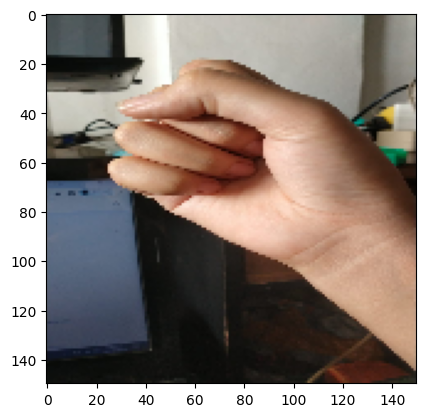

In [28]:
uploaded = files.upload()

class_labels = os.listdir(base_dir)

for fn in uploaded.keys():

  # predicting images
  img = tf.keras.utils.load_img(fn, target_size=(150, 150))  # Resize to 150x150 pixels
  imgplot = plt.imshow(img)
  img_array = tf.keras.utils.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)  # Add an extra dimension for batch size
  img_array /= 255.0  # Rescale the pixel values to [0, 1]

  predicted_probabilities = model.predict(img_array)

  predicted_class = np.argmax(predicted_probabilities)
  print(class_labels[predicted_class])

## 5. Conclusion
In this project, we walked through the process of preparing a dataset for a rock-paper-scissors image classification task. I cleaned the dataset, organized it into training and validation sets, and removed any unnecessary files and directories. I then applied data augmentation to enrich the training data and built a convolutional neural network (CNN) model using TensorFlow and Keras.

The model was trained on the augmented dataset, and its final validation accuracy exceeded the 85% threshold, indicating a successful classification model.

Additionally, we provided an interactive section to upload and predict the classes of custom images using the trained model, demonstrating its real-world applicability.

It's a great starting point for understanding data preprocessing, model development, and image classification with deep learning.

Thank you for following along with this project!

## 6 .Acknowledgments
Acknowledging the dataset provided by Dicoding Academy for this project, which can be found [here](https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip).

The model's final validation accuracy was achieved using the power of deep learning and neural networks, and it showcases the capabilities of open-source tools and libraries.